# Elephants Binary Classification using Deep Learning

This notebook implements a binary image classification solution for detecting African and Asian elephants using images. We'll compare three different models:
1. Basic CNN model
2. Improved CNN with BatchNormalization
3. Pre-trained ResNet50 model

The dataset contains elephants images classified as either African or Asian.

## Setup and Import Libraries

First, let's import all the necessary libraries and set up our environment.

In [16]:
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,UpSampling2D, Dropout
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from google.colab import drive
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

In [17]:
# Mounting the drive where the dataset resides
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
# Define paths to the dataset
train_dir = '/content/drive/MyDrive/Elephants/train'  # training path
test_dir = '/content/drive/MyDrive/Elephants/test'    # testing path

Dataset Statistics:
Training African Elephants images: 420
Training Asian Elephants images: 420
Test African Elephants images: 97
Test Asian Elephants images: 91


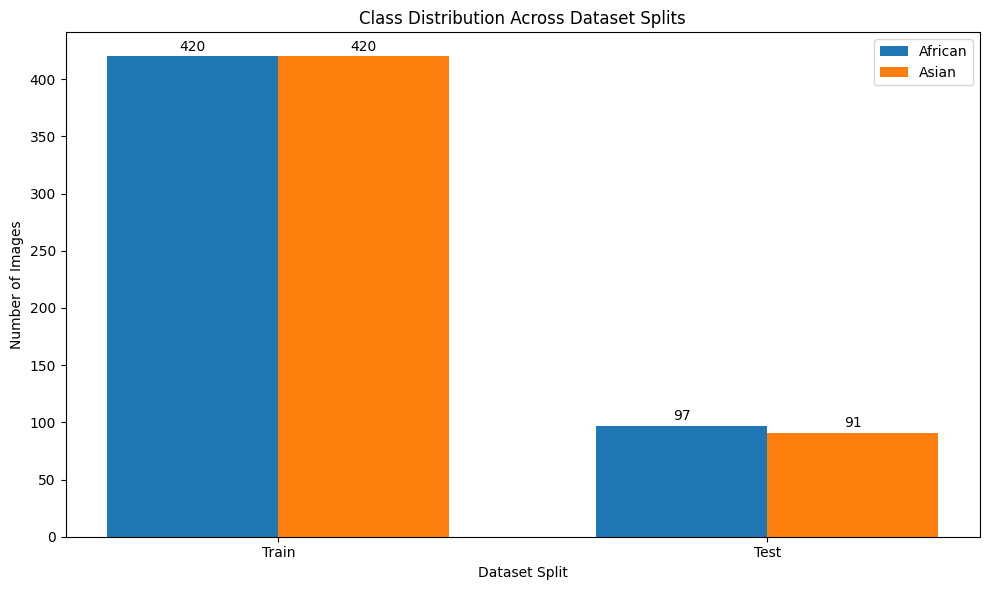

In [19]:
# Print dataset statistics
print("Dataset Statistics:")
print(f"Training African Elephants images: {len(os.listdir('/content/drive/MyDrive/Elephants/train/African'))}")
print(f"Training Asian Elephants images: {len(os.listdir('/content/drive/MyDrive/Elephants/train/Asian'))}")
print(f"Test African Elephants images: {len(os.listdir('/content/drive/MyDrive/Elephants/test/African'))}")
print(f"Test Asian Elephants images: {len(os.listdir('/content/drive/MyDrive/Elephants/test/Asian'))}")

# Plot class distribution
categories = ['Train', 'Test']
african_counts = [len(os.listdir('/content/drive/MyDrive/Elephants/train/African')), len(os.listdir('/content/drive/MyDrive/Elephants/test/African'))]
asian_counts = [len(os.listdir('/content/drive/MyDrive/Elephants/train/Asian')), len(os.listdir('/content/drive/MyDrive/Elephants/test/Asian'))]

x = np.arange(len(categories))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, african_counts, width, label='African')
plt.bar(x + width/2, asian_counts, width, label='Asian')

plt.xlabel('Dataset Split')
plt.ylabel('Number of Images')
plt.title('Class Distribution Across Dataset Splits')
plt.xticks(x, categories)
plt.legend()

# Add count labels on bars
for i, v in enumerate(african_counts):
    plt.text(i - width/2, v + 5, str(v), ha='center')
for i, v in enumerate(asian_counts):
    plt.text(i + width/2, v + 5, str(v), ha='center')

plt.tight_layout()
plt.show()

## Data Preprocessing and Augmentation

Now, let's preprocess the data and set it up for training.

In [20]:
# Create ImageDataGenerator for training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # Split 20% of the images for validation
)

# Load and prepare training data
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(256,256),
    batch_size=32,
    class_mode='binary',  # 'binary' for binary classification
    subset='training'  # Specify 'training' for the training set
)

# Create ImageDataGenerator for validation set
validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # Note: Using the same validation split as in the training set
)

# Load and prepare validation data
validation_data = validation_datagen.flow_from_directory(
    train_dir,
    target_size=(256,256),
    batch_size=32,
    class_mode='binary',
    subset='validation'  # Specify 'validation' for the validation set
)

Found 672 images belonging to 2 classes.
Found 168 images belonging to 2 classes.


## Model 1: Basic CNN Model

Let's implement and train a basic CNN model for skin cancer classification.

In [21]:
# create CNN model
print("\n--- Training Basic CNN Model ---\n")

basic_model = Sequential()

basic_model.add(Conv2D(32,kernel_size=(3,3),padding='valid',activation='relu',input_shape=(256,256,3)))  # 32 filters
basic_model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

basic_model.add(Conv2D(64,kernel_size=(3,3),padding='valid',activation='relu'))
basic_model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

basic_model.add(Conv2D(128,kernel_size=(3,3),padding='valid',activation='relu'))
basic_model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

basic_model.add(Flatten())

basic_model.add(Dense(128,activation='relu')) #feature reduction
basic_model.add(Dense(64,activation='relu'))
basic_model.add(Dense(1,activation='sigmoid'))  #output layer

# Display model summary
basic_model.summary()

# Train the model
basic_model.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy']) #binary_crossentropy - binary classification
basic_history = basic_model.fit(train_data, epochs=20, validation_data=validation_data)


--- Training Basic CNN Model ---



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,297 (56.64 MB)

 Trainable params: 14,847,297 (56.64 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 190ms/step - accuracy: 0.4934 - loss: 0.8972 - val_accuracy: 0.5000 - val_loss: 0.6967
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step - accuracy: 0.5545 - loss: 0.6807 - val_accuracy: 0.5476 - val_loss: 0.7182
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 169ms/step - accuracy: 0.6088 - loss: 0.6535 - val_accuracy: 0.5238 - val_loss: 0.7753
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - accuracy: 0.6648 - loss: 0.5884 - val_accuracy: 0.5238 - val_loss: 0.8415
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 154ms/step - accuracy: 0.7474 - loss: 0.5311 - val_accuracy: 0.5179 - val_loss: 0.8648
Epoch 6/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 194ms/step - accuracy: 0.7804 - loss: 0.4491 - val_accuracy: 0.4940 - val_loss: 1.0481
Epoch 7/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 155ms/step - accuracy: 0.8529 - loss: 0.3559 - val_accuracy: 0.4881 - val_loss: 1.2934
Epoch 8/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - accuracy: 0.8788 - loss: 0.2931 - val_accuracy: 0.

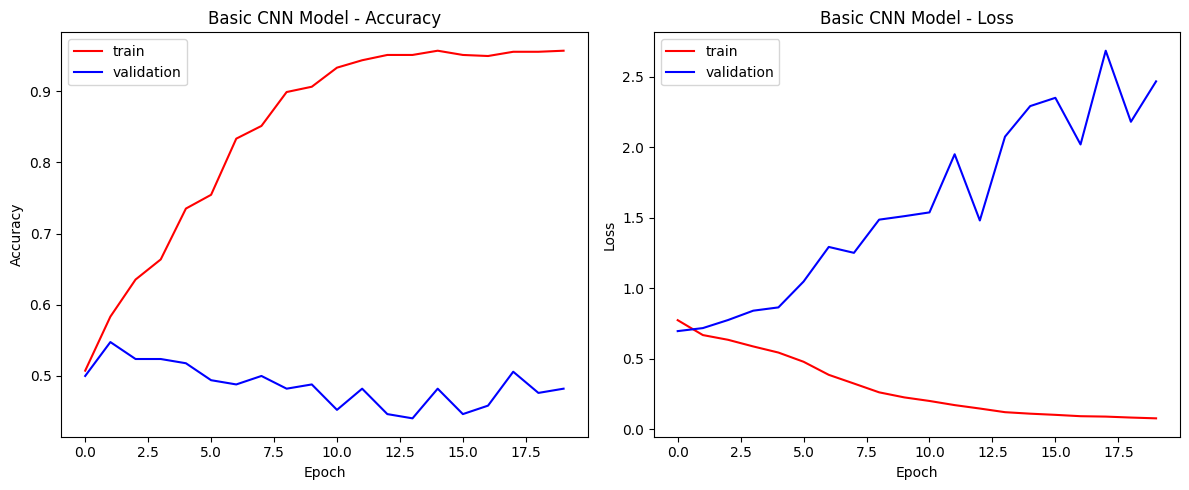

In [22]:
# Plot training history - Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(basic_history.history['accuracy'], color='red', label='train')
plt.plot(basic_history.history['val_accuracy'], color='blue', label='validation')
plt.title('Basic CNN Model - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training history - Loss
plt.subplot(1, 2, 2)
plt.plot(basic_history.history['loss'], color='red', label='train')
plt.plot(basic_history.history['val_loss'], color='blue', label='validation')
plt.title('Basic CNN Model - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [23]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(256,256),
    batch_size=32,
    class_mode='binary'
)

# Evaluate on test data
basic_predictions = basic_model.predict(test_data)
basic_predicted_labels = (basic_predictions > 0.5).astype(int)

# Calculate confusion matrix and classification report
basic_cm = confusion_matrix(test_data.classes, basic_predicted_labels)
basic_cr = classification_report(test_data.classes, basic_predicted_labels)

print("\nBasic CNN Model - Confusion Matrix:")
print(basic_cm)
print("\nBasic CNN Model - Classification Report:")
print(basic_cr)

Found 188 images belonging to 2 classes.
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 435ms/step

Basic CNN Model - Confusion Matrix:
[[35 62]
 [42 49]]

Basic CNN Model - Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.36      0.40        97
           1       0.44      0.54      0.49        91

    accuracy                           0.45       188
   macro avg       0.45      0.45      0.44       188
weighted avg       0.45      0.45      0.44       188



## Model 2: Improved CNN Model with BatchNormalization

Now, let's implement and train an improved CNN model with BatchNormalization to reduce overfitting.

In [24]:
print("\n--- Training Improved CNN Model with BatchNormalization ---\n")

improved_model = Sequential()

improved_model.add(Conv2D(32,kernel_size=(3,3),padding='valid',activation='relu',input_shape=(256,256,3)))  # 32 filters
improved_model.add(BatchNormalization())  # added to reduce overfitting
improved_model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

improved_model.add(Conv2D(64,kernel_size=(3,3),padding='valid',activation='relu'))
improved_model.add(BatchNormalization())  # added to reduce overfitting
improved_model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

improved_model.add(Conv2D(128,kernel_size=(3,3),padding='valid',activation='relu'))
improved_model.add(BatchNormalization())  # added to reduce overfitting
improved_model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

improved_model.add(Flatten())

improved_model.add(Dense(128,activation='relu')) #feature reduction
improved_model.add(Dropout(0.1))  # added to reduce overfitting
improved_model.add(Dense(64,activation='relu'))
improved_model.add(Dropout(0.1))  # added to reduce overfitting
improved_model.add(Dense(1,activation='sigmoid'))  #output layer


improved_model.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])
improved_history = improved_model.fit(train_data, epochs=20, validation_data=validation_data)



--- Training Improved CNN Model with BatchNormalization ---



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 216ms/step - accuracy: 0.5362 - loss: 6.8677 - val_accuracy: 0.5238 - val_loss: 3.2071
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step - accuracy: 0.6173 - loss: 3.5929 - val_accuracy: 0.4643 - val_loss: 10.0133
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - accuracy: 0.6730 - loss: 1.7478 - val_accuracy: 0.5000 - val_loss: 16.0349
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 192ms/step - accuracy: 0.6084 - loss: 1.8030 - val_accuracy: 0.5536 - val_loss: 2.2887
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 163ms/step - accuracy: 0.6741 - loss: 1.1747 - val_accuracy: 0.5655 - val_loss: 2.9257
Epoch 6/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - accuracy: 0.6667 - loss: 1.3767 - val_accuracy: 0.5536 - val_loss: 1.7196
Epoch 7/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - accuracy: 0.6881 - loss: 1.1945 - val_accuracy: 0.5119 - val_loss: 7.5160
Epoch 8/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 201ms/step - accuracy: 0.7293 - loss: 1.0368 - val_accuracy:

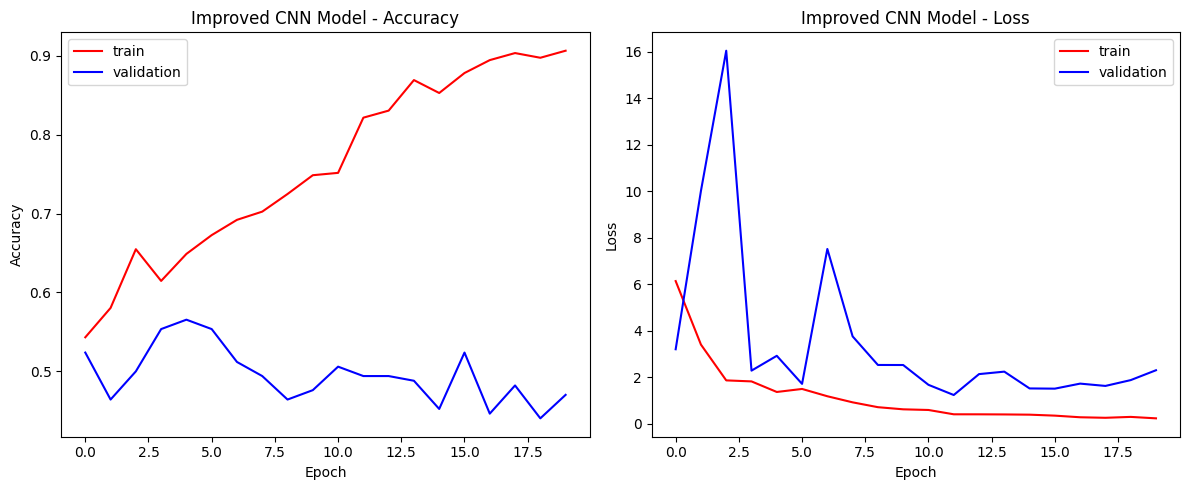

In [25]:
# Plot training history - Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(improved_history.history['accuracy'], color='red', label='train')
plt.plot(improved_history.history['val_accuracy'], color='blue', label='validation')
plt.title('Improved CNN Model - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training history - Loss
plt.subplot(1, 2, 2)
plt.plot(improved_history.history['loss'], color='red', label='train')
plt.plot(improved_history.history['val_loss'], color='blue', label='validation')
plt.title('Improved CNN Model - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [26]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(256,256),
    batch_size=32,
    class_mode='binary'
)


predictions = improved_model.predict(test_data)

# Evaluate on test data
improved_predictions = improved_model.predict(test_data)
improved_predicted_labels = (improved_predictions > 0.5).astype(int)

# Calculate confusion matrix and classification report
improved_cm = confusion_matrix(test_data.classes, improved_predicted_labels)
improved_cr = classification_report(test_data.classes, improved_predicted_labels)

print("\nImproved CNN Model - Confusion Matrix:")
print(improved_cm)
print("\nImproved CNN Model - Classification Report:")
print(improved_cr)

Found 188 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 542ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 433ms/step

Improved CNN Model - Confusion Matrix:
[[36 61]
 [38 53]]

Improved CNN Model - Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.37      0.42        97
           1       0.46      0.58      0.52        91

    accuracy                           0.47       188
   macro avg       0.48      0.48      0.47       188
weighted avg       0.48      0.47      0.47       188



## Model 3: Pre-trained ResNet50 Model with Transfer Learning

Finally, let's implement and train a pre-trained ResNet50 model.

In [27]:
print("\n--- Training Pre-trained ResNet50 Model ---\n")

resnet_model = Sequential()    #ResNet50 is a pre-trained model
pretrained_model = tf.keras.applications.ResNet50(
    include_top = False, #because i have my own image of a diff dimension
    input_shape = (256,256,3),
    pooling = 'max', classes = 2,
    weights = 'imagenet')

# Freeze the pre-trained layers
for layer in pretrained_model.layers:
    layer.trainable = False

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation = 'relu'))
resnet_model.add(Dense(1, activation = 'sigmoid'))


resnet_model.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])

# Display model summary
resnet_model.summary()

resnet_history = resnet_model.fit(train_data, epochs=20, validation_data=validation_data)




--- Training Pre-trained ResNet50 Model ---



Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,637,313 (93.98 MB)

 Trainable params: 1,049,601 (4.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 19s 447ms/step - accuracy: 0.5205 - loss: 4.4425 - val_accuracy: 0.5000 - val_loss: 1.8278
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 168ms/step - accuracy: 0.4893 - loss: 1.5710 - val_accuracy: 0.5000 - val_loss: 1.0604
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 161ms/step - accuracy: 0.5190 - loss: 0.8982 - val_accuracy: 0.5298 - val_loss: 0.7078
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 171ms/step - accuracy: 0.5296 - loss: 0.7482 - val_accuracy: 0.5298 - val_loss: 0.7411
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 201ms/step - accuracy: 0.6093 - loss: 0.6544 - val_accuracy: 0.5655 - val_loss: 0.7014
Epoch 6/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 172ms/step - accuracy: 0.6450 - loss: 0.6307 - val_accuracy: 0.5238 - val_loss: 0.7713
Epoch 7/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 166ms/step - accuracy: 0.6049 - loss: 0.7182 - val_accuracy: 0.5595 - val_loss: 0.7068
Epoch 8/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 180ms/step - accuracy: 0.6676 - loss: 0.6053 - val_accuracy: 0

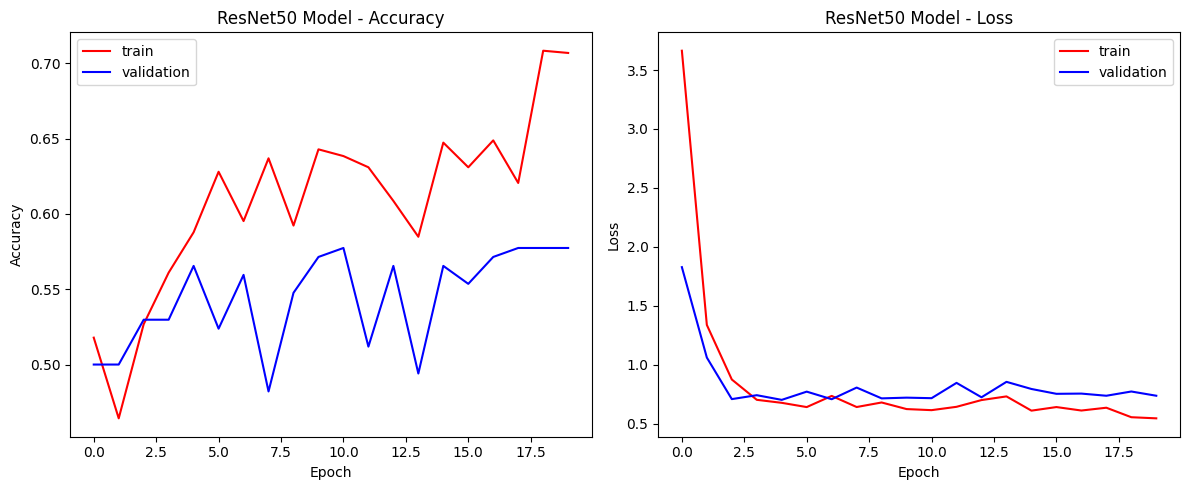

In [28]:
# Plot training history - Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(resnet_history.history['accuracy'], color='red', label='train')
plt.plot(resnet_history.history['val_accuracy'], color='blue', label='validation')
plt.title('ResNet50 Model - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training history - Loss
plt.subplot(1, 2, 2)
plt.plot(resnet_history.history['loss'], color='red', label='train')
plt.plot(resnet_history.history['val_loss'], color='blue', label='validation')
plt.title('ResNet50 Model - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [29]:

# Evaluate on test data
resnet_predictions = resnet_model.predict(test_data)
resnet_predicted_labels = (resnet_predictions > 0.5).astype(int)

# Calculate confusion matrix and classification report
resnet_cm = confusion_matrix(test_data.classes, resnet_predicted_labels)
resnet_cr = classification_report(test_data.classes, resnet_predicted_labels)

print("\nResNet50 Model - Confusion Matrix:")
print(resnet_cm)
print("\nResNet50 Model - Classification Report:")
print(resnet_cr)

6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step

ResNet50 Model - Confusion Matrix:
[[62 35]
 [52 39]]

ResNet50 Model - Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.64      0.59        97
           1       0.53      0.43      0.47        91

    accuracy                           0.54       188
   macro avg       0.54      0.53      0.53       188
weighted avg       0.54      0.54      0.53       188



## Model Performance Comparison

Let's compare the performance of all three models using various evaluation metrics.


--- Model Performance Comparison ---



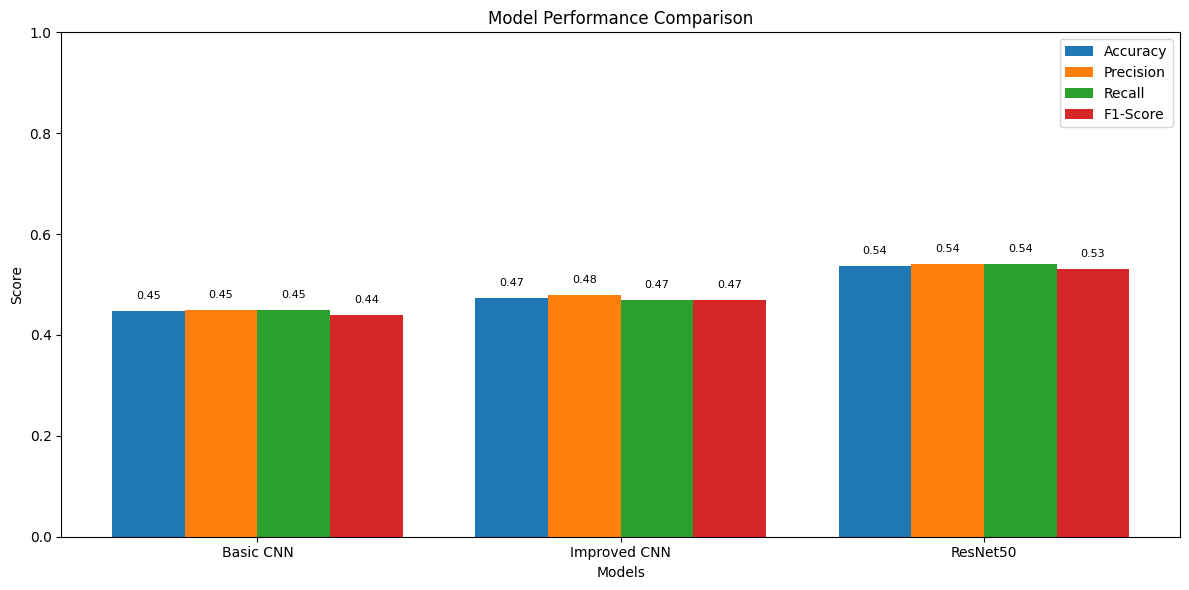

Model Performance Comparison Table:
          Model  Accuracy  Precision  Recall  F1-Score
0     Basic CNN    0.4468       0.45    0.45      0.44
1  Improved CNN    0.4734       0.48    0.47      0.47
2      ResNet50    0.5372       0.54    0.54      0.53

All models trained and evaluated successfully!


In [30]:
print("\n--- Model Performance Comparison ---\n")

# Function to extract metrics from classification report
def extract_metrics(report_text):
    lines = report_text.strip().split('\n')
    # Find the line with weighted avg
    for line in lines:
        if 'weighted avg' in line:
            parts = line.split()
            precision = float(parts[2])
            recall = float(parts[3])
            f1 = float(parts[4])
            return precision, recall, f1
    return None, None, None

# Extract metrics
basic_precision, basic_recall, basic_f1 = extract_metrics(basic_cr)
improved_precision, improved_recall, improved_f1 = extract_metrics(improved_cr)
resnet_precision, resnet_recall, resnet_f1 = extract_metrics(resnet_cr)

# Calculate accuracy from confusion matrix
basic_accuracy = np.trace(basic_cm) / np.sum(basic_cm)
improved_accuracy = np.trace(improved_cm) / np.sum(improved_cm)
resnet_accuracy = np.trace(resnet_cm) / np.sum(resnet_cm)

# Create comparison plot
models = ['Basic CNN', 'Improved CNN', 'ResNet50']
accuracy = [basic_accuracy, improved_accuracy, resnet_accuracy]
precision = [basic_precision, improved_precision, resnet_precision]
recall = [basic_recall, improved_recall, resnet_recall]
f1 = [basic_f1, improved_f1, resnet_f1]

x = np.arange(len(models))
width = 0.2

plt.figure(figsize=(12, 6))
plt.bar(x - width*1.5, accuracy, width, label='Accuracy')
plt.bar(x - width/2, precision, width, label='Precision')
plt.bar(x + width/2, recall, width, label='Recall')
plt.bar(x + width*1.5, f1, width, label='F1-Score')

plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(x, models)
plt.legend()
plt.ylim(0, 1.0)

# Add value labels
for i, v in enumerate(accuracy):
    plt.text(i - width*1.5, v + 0.02, f'{v:.2f}', ha='center', va='bottom', fontsize=8)
for i, v in enumerate(precision):
    plt.text(i - width/2, v + 0.02, f'{v:.2f}', ha='center', va='bottom', fontsize=8)
for i, v in enumerate(recall):
    plt.text(i + width/2, v + 0.02, f'{v:.2f}', ha='center', va='bottom', fontsize=8)
for i, v in enumerate(f1):
    plt.text(i + width*1.5, v + 0.02, f'{v:.2f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

# Create a comparison table
import pandas as pd

comparison_df = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
})

print("Model Performance Comparison Table:")
print(comparison_df.round(4))

print("\nAll models trained and evaluated successfully!")